# IMDB电影评论的情感分析

## 1. 实验环境

In [1]:
# 导入paddle及相关包
import paddle
import paddle.nn.functional as F
import re
import random
import tarfile
import requests
import numpy as np

paddle.seed(0)
random.seed(0)
np.random.seed(0)
print(paddle.__version__)

2.6.1


## 2. 数据处理

### 2.1 数据下载

In [2]:
def download():
    # 通过python的requests类，下载存储在
    # https://dataset.bj.bcebos.com/imdb%2FaclImdb_v1.tar.gz的文件
    corpus_url = "https://dataset.bj.bcebos.com/imdb%2FaclImdb_v1.tar.gz"
    web_request = requests.get(corpus_url)
    corpus = web_request.content

    # 将下载的文件写在当前目录的aclImdb_v1.tar.gz文件内
    with open("./aclImdb_v1.tar.gz", "wb") as f:
        f.write(corpus)
    f.close()

download()

### 2.2 数据读取

In [3]:
# 读取数据
def load_imdb(is_training):

    # 将读取的数据放到列表data_set里
    data_set = []

    # data_set中每个元素都是一个二元组：(句子，label)，其中label=0表示消极情感，label=1表示积极情感
    for label in ["pos", "neg"]:
        with tarfile.open("./aclImdb_v1.tar.gz") as tarf:
            path_pattern = "aclImdb/train/" + label + "/.*\.txt$" if is_training \
                else "aclImdb/test/" + label + "/.*\.txt$"
            path_pattern = re.compile(path_pattern)
            tf = tarf.next()
            while tf != None:
                if bool(path_pattern.match(tf.name)):
                    sentence = tarf.extractfile(tf).read().decode()
                    sentence_label = 0 if label == 'neg' else 1
                    data_set.append((sentence, sentence_label))
                tf = tarf.next()

    return data_set

train_corpus = load_imdb(True)
test_corpus = load_imdb(False)

# 打印第一条数据，查看数据格式：(句子，label)
print(train_corpus[0])

('Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn\'t really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I\'d have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.', 1)


### 2.3 数据格式转换

#### 2.3.1 分词

In [4]:
def data_preprocess(corpus):
    data_set = []
    for sentence, sentence_label in corpus:
        # 将所有的句子转换为小写，一方面可以减小词表的大小，另一方面也有助于效果提升
        sentence = sentence.strip().lower()
        sentence = sentence.split(" ")

        data_set.append((sentence, sentence_label))

    return data_set

train_set = data_preprocess(train_corpus)
test_set = data_preprocess(test_corpus)

# 打印训练集中的第一条数据
print(train_set[0])

(['zentropa', 'has', 'much', 'in', 'common', 'with', 'the', 'third', 'man,', 'another', 'noir-like', 'film', 'set', 'among', 'the', 'rubble', 'of', 'postwar', 'europe.', 'like', 'ttm,', 'there', 'is', 'much', 'inventive', 'camera', 'work.', 'there', 'is', 'an', 'innocent', 'american', 'who', 'gets', 'emotionally', 'involved', 'with', 'a', 'woman', 'he', "doesn't", 'really', 'understand,', 'and', 'whose', 'naivety', 'is', 'all', 'the', 'more', 'striking', 'in', 'contrast', 'with', 'the', 'natives.<br', '/><br', '/>but', "i'd", 'have', 'to', 'say', 'that', 'the', 'third', 'man', 'has', 'a', 'more', 'well-crafted', 'storyline.', 'zentropa', 'is', 'a', 'bit', 'disjointed', 'in', 'this', 'respect.', 'perhaps', 'this', 'is', 'intentional:', 'it', 'is', 'presented', 'as', 'a', 'dream/nightmare,', 'and', 'making', 'it', 'too', 'coherent', 'would', 'spoil', 'the', 'effect.', '<br', '/><br', '/>this', 'movie', 'is', 'unrelentingly', 'grim--"noir"', 'in', 'more', 'than', 'one', 'sense;', 'one', '

#### 2.3.2 组建词表

In [5]:
# 构造词典，统计每个词的频率，并根据频率将每个词转换为一个整数id
def build_dict(corpus):
    word_freq_dict = dict()
    for sentence, _ in corpus:
        for word in sentence:
            if word not in word_freq_dict:
                word_freq_dict[word] = 0
            word_freq_dict[word] += 1

    word_freq_dict = sorted(word_freq_dict.items(), key = lambda x:x[1], reverse = True)

    word2id_dict = dict()
    word2id_freq = dict()

    # 一般来说，我们把oov和pad放在词典前面，给他们一个比较小的id，这样比较方便记忆，并且易于后续扩展词表
    word2id_dict['[oov]'] = 0
    word2id_freq[0] = 1e10

    word2id_dict['[pad]'] = 1
    word2id_freq[1] = 1e10

    for word, freq in word_freq_dict:
        word2id_dict[word] = len(word2id_dict)
        word2id_freq[word2id_dict[word]] = freq

    return word2id_freq, word2id_dict

word2id_freq, word2id_dict = build_dict(train_set)
vocab_size = len(word2id_freq)
print("there are totoally %d different words in the corpus" % vocab_size)
for _, (word, word_id) in zip(range(5), word2id_dict.items()):
    print("word %s, its id %d, its word freq %d" % (word, word_id, word2id_freq[word_id]))

there are totoally 252173 different words in the corpus
word [oov], its id 0, its word freq 10000000000
word [pad], its id 1, its word freq 10000000000
word the, its id 2, its word freq 322174
word a, its id 3, its word freq 159949
word and, its id 4, its word freq 158556


#### 2.3.3 映射为词典id

In [6]:
# 把语料转换为id序列
def convert_corpus_to_id(corpus, word2id_dict):
    data_set = []
    for sentence, sentence_label in corpus:
        sentence = [word2id_dict[word] if word in word2id_dict \
                        else word2id_dict['[oov]'] for word in sentence]
        data_set.append((sentence, sentence_label))
    return data_set

train_set = convert_corpus_to_id(train_set, word2id_dict)
test_set = convert_corpus_to_id(test_set, word2id_dict)

# 打印训练数据中的第一条文本
print(train_set[0])

([22216, 41, 76, 8, 1136, 17, 2, 874, 979, 167, 69425, 24, 283, 707, 2, 19881, 5, 16628, 11952, 37, 100421, 52, 7, 76, 5733, 415, 912, 52, 7, 32, 1426, 299, 36, 195, 2299, 644, 17, 3, 282, 27, 141, 61, 7447, 4, 555, 25364, 7, 35, 2, 51, 3590, 8, 2691, 17, 2, 69426, 13, 688, 428, 26, 6, 142, 11, 2, 874, 160, 41, 3, 51, 14841, 4458, 22216, 7, 3, 218, 6262, 8, 10, 6919, 382, 10, 7, 100422, 12, 7, 1394, 15, 3, 100423, 4, 242, 12, 104, 5041, 54, 2368, 2, 4828, 109, 13, 255, 20, 7, 32280, 100424, 8, 51, 68, 30, 29571, 30, 102, 1010, 2, 4142, 18952, 11069, 18, 11636, 4, 12644], 1)


### 2.4 组装mini-batch

In [7]:
def build_batch(word2id_dict, corpus, batch_size, epoch_num, max_seq_len, shuffle = True, drop_last = True):

    sentence_batch = []
    sentence_label_batch = []

    for _ in range(epoch_num):

        #每个epoch前都shuffle一下数据，有助于提高模型训练的效果。但是对于预测任务，不要做数据shuffle
        if shuffle:
            random.shuffle(corpus)

        for sentence, sentence_label in corpus:
            sentence_sample = sentence[:min(max_seq_len, len(sentence))]
            if len(sentence_sample) < max_seq_len:
                for _ in range(max_seq_len - len(sentence_sample)):
                    sentence_sample.append(word2id_dict['[pad]'])

            sentence_batch.append(sentence_sample)
            sentence_label_batch.append([sentence_label])

            if len(sentence_batch) == batch_size:
                yield np.array(sentence_batch).astype("int64"), np.array(sentence_label_batch).astype("int64")
                sentence_batch = []
                sentence_label_batch = []
    if not drop_last and len(sentence_batch) > 0:
        yield np.array(sentence_batch).astype("int64"), np.array(sentence_label_batch).astype("int64")

batch_iters = build_batch(word2id_dict, train_set, batch_size=3, epoch_num=3, max_seq_len=30)
# 答应第一个batch，查看数据shape
batch = next(batch_iters)
print("batch type: ", type(batch))
print("text shape: ", batch[0].shape)
print("label shape: ", batch[1].shape)

batch type:  <class 'tuple'>
text shape:  (3, 30)
label shape:  (3, 1)


## 3. 模型构建

In [40]:
# 定义一个用于情感分类的网络实例，SentimentClassifier
class SentimentClassifier(paddle.nn.Layer):

    def __init__(self, hidden_size, vocab_size, embedding_size, class_num=2, num_steps=128, num_layers=1, init_scale=0.1, dropout_rate=None):

        # 参数含义如下：
        # 1.hidden_size，表示embedding-size，hidden和cell向量的维度
        # 2.vocab_size，模型可以考虑的词表大小
        # 3.embedding_size，表示词向量的维度
        # 4.class_num，情感类型个数，可以是2分类，也可以是多分类
        # 5.num_steps，表示这个情感分析模型最大可以考虑的句子长度
        # 6.num_layers，表示网络的层数
        # 7.dropout_rate，表示使用dropout过程中失活的神经元比例
        # 8.init_scale，表示网络内部的参数的初始化范围,长短时记忆网络内部用了很多Tanh，Sigmoid等激活函数，\
        # 这些函数对数值精度非常敏感，因此我们一般只使用比较小的初始化范围，以保证效果
        super(SentimentClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.class_num = class_num
        self.num_steps = num_steps
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.init_scale = init_scale

        # 声明一个LSTM模型，用来把每个句子抽象成向量
        self.simple_lstm_rnn = paddle.nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers)

        # 声明一个embedding层，用来把句子中的每个词转换为向量
        self.embedding = paddle.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size, sparse=False,
                                             weight_attr=paddle.ParamAttr(initializer=paddle.nn.initializer.Uniform(low=-init_scale, high=init_scale)))

        # 声明使用上述语义向量映射到具体情感类别时所需要使用的线性层
        self.cls_fc = paddle.nn.Linear(in_features=self.hidden_size, out_features=self.class_num,
                                       weight_attr=None, bias_attr=None)

        # 一般在获取单词的embedding后，会使用dropout层，防止过拟合，提升模型泛化能力
        self.dropout_layer = paddle.nn.Dropout(p=self.dropout_rate, mode='upscale_in_train')

    # forwad函数即为模型前向计算的函数，它有两个输入，分别为：
    # input为输入的训练文本，其shape为[batch_size, max_seq_len]
    # label训练文本对应的情感标签，其shape维[batch_size, 1]
    def forward(self, inputs):
        # 获取输入数据的batch_size
        batch_size = inputs.shape[0]

        # 本实验默认使用1层的LSTM，首先我们需要定义LSTM的初始hidden和cell，这里我们使用0来初始化这个序列的记忆
        init_hidden_data = np.zeros(
            (self.num_layers, batch_size, self.hidden_size), dtype='float32')
        init_cell_data = np.zeros(
            (self.num_layers, batch_size, self.hidden_size), dtype='float32')

        # 将这些初始记忆转换为飞桨可计算的向量，并且设置stop_gradient=True，避免这些向量被更新，从而影响训练效果
        init_hidden = paddle.to_tensor(init_hidden_data)
        init_hidden.stop_gradient = True
        init_cell = paddle.to_tensor(init_cell_data)
        init_cell.stop_gradient = True

        # 对应以上第2步，将输入的句子的mini-batch转换为词向量表示，转换后输入数据shape为[batch_size, max_seq_len, embedding_size]
        x_emb = self.embedding(inputs)
        x_emb = paddle.reshape(x_emb, shape=[-1, self.num_steps, self.embedding_size])
        # 在获取的词向量后添加dropout层
        if self.dropout_rate is not None and self.dropout_rate > 0.0:
            x_emb = self.dropout_layer(x_emb)

        # 对应以上第3步，使用LSTM网络，把每个句子转换为语义向量
        # 返回的last_hidden即为最后一个时间步的输出，其shape为[self.num_layers, batch_size, hidden_size]
        rnn_out, (last_hidden, last_cell) = self.simple_lstm_rnn(x_emb, (init_hidden, init_cell))
        # 提取最后一层隐状态作为文本的语义向量，其shape为[batch_size, hidden_size]
        last_hidden = paddle.reshape(last_hidden[-1], shape=[-1, self.hidden_size])

        # 对应以上第4步，将每个句子的向量表示映射到具体的情感类别上, logits的维度为[batch_size, 2]
        logits = self.cls_fc(last_hidden)

        return logits

## 4. 训练配置

In [73]:
# 定义训练参数
epoch_num = 5
batch_size = 128

learning_rate = 0.005
dropout_rate = 0.2
num_layers = 1
hidden_size = 128
embedding_size = 128
max_seq_len = 128
vocab_size = len(word2id_freq)

# 检测是否可以使用GPU，如果可以优先使用GPU
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu:0')

# 实例化模型
sentiment_classifier = SentimentClassifier(hidden_size, vocab_size, embedding_size,  num_steps=max_seq_len, num_layers=num_layers, dropout_rate=dropout_rate)

# 指定优化策略，更新模型参数
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999, parameters= sentiment_classifier.parameters()) 

## 5. 模型训练

### 5.1 训练过程

In [74]:
# 记录训练过程中的损失变化情况，可用于后续画图查看训练情况
losses = []
steps = []

def train(model):
    # 开启模型训练模式
    model.train()

    # 建立训练数据生成器，每次迭代生成一个batch，每个batch包含训练文本和文本对应的情感标签
    train_generator = build_batch(word2id_dict, train_set, batch_size, epoch_num, max_seq_len)

    for step, (sentences, labels) in enumerate(train_generator):
        # 获取数据，并将张量转换为Tensor类型
        sentences = paddle.to_tensor(sentences)
        labels = paddle.to_tensor(labels)

        # 前向计算，将数据feed进模型，并得到预测的情感标签和损失
        logits = model(sentences)

        # 计算损失
        loss = F.cross_entropy(input=logits, label=labels, soft_label=False)
        loss = paddle.mean(loss)

        # 后向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 清除梯度
        optimizer.clear_grad()

        if step % 100 == 0:
            # 记录当前步骤的loss变化情况
            losses.append(loss.numpy())
            steps.append(step)
            # 打印当前loss数值
            print("step %d, loss %.3f" % (step, loss.numpy()))

train(sentiment_classifier)

step 0, loss 0.693
step 100, loss 0.701
step 200, loss 0.649
step 300, loss 0.446
step 400, loss 0.062
step 500, loss 0.094
step 600, loss 0.057
step 700, loss 0.006
step 800, loss 0.001
step 900, loss 0.000


### 5.2 训练可视化

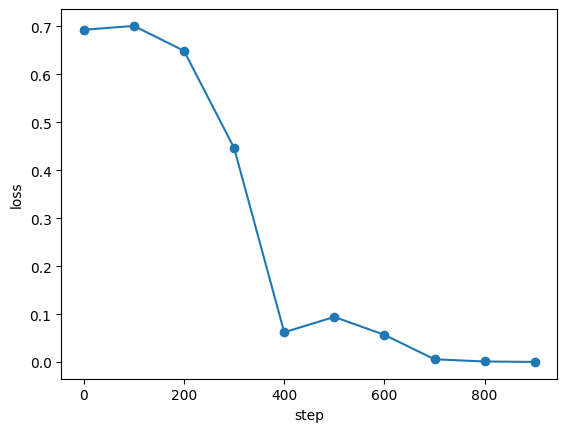

In [75]:
import matplotlib.pyplot as plt

# 开始画图，横轴是训练step，纵轴是损失
plt.plot(steps, losses, "-o")
plt.xlabel("step")
plt.ylabel("loss")
plt.savefig("./loss.png")

## 6. 模型保存

In [76]:
model_name = "sentiment_classifier"

# 保存训练好的模型参数
paddle.save(sentiment_classifier.state_dict(), "{}.pdparams".format(model_name))
# 保存优化器参数，方便后续模型继续训练
paddle.save(optimizer.state_dict(), "{}.pdopt".format(model_name))

## 7. 模型评估

TP: 8596
FP: 1928
TN: 10555
FN: 3881

Accuracy: 0.7673


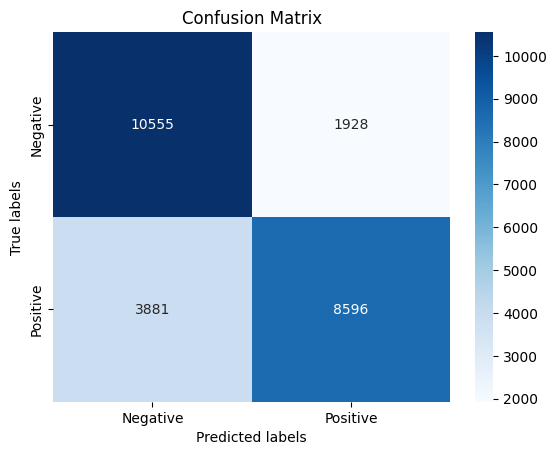

In [85]:
import seaborn as sns


def evaluate(model):
    # 开启模型测试模式，在该模式下，网络不会进行梯度更新
    model.eval()

    # 定义以上几个统计指标
    tp, tn, fp, fn = 0, 0, 0, 0

    # 构造测试数据生成器
    test_generator = build_batch(word2id_dict, test_set, batch_size, 1, max_seq_len)

    for sentences, labels in test_generator:
        # 将张量转换为Tensor类型
        sentences = paddle.to_tensor(sentences)
        labels = paddle.to_tensor(labels)
        # 获取模型对当前batch的输出结果
        logits = model(sentences)

        # 使用softmax进行归一化
        probs = F.softmax(logits)

        # 把输出结果转换为numpy array数组，比较预测结果和对应label之间的关系，并更新tp，tn，fp和fn
        probs = probs.numpy()
        for i in range(len(probs)):
            # 当样本是的真实标签是正例
            if labels[i][0] == 1:
                # 模型预测是正例
                if probs[i][1] > probs[i][0]:
                    tp += 1
                # 模型预测是负例
                else:
                    fn += 1
            # 当样本的真实标签是负例
            else:
                # 模型预测是正例
                if probs[i][1] > probs[i][0]:
                    fp += 1
                # 模型预测是负例
                else:
                    tn += 1

    # 整体准确率
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # 输出最终评估的模型效果
    print("TP: {}\nFP: {}\nTN: {}\nFN: {}\n".format(tp, fp, tn, fn))
    print("Accuracy: %.4f" % accuracy)

    # 绘制混淆矩阵热力图
    confusion_matrix = np.array([[tn, fp], [fn, tp]])
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# 加载训练好的模型进行预测，重新实例化一个模型，然后将训练好的模型参数加载到新模型里面
saved_state = paddle.load("./sentiment_classifier.pdparams")
sentiment_classifier = SentimentClassifier(hidden_size, vocab_size, embedding_size,  num_steps=max_seq_len, num_layers=num_layers, dropout_rate=dropout_rate)
sentiment_classifier.load_dict(saved_state)

# 评估模型
evaluate(sentiment_classifier)

## 8. 模型推理

In [87]:
# 模型预测代码
def infer(model, text):
    model.eval()
    # 数据处理
    sentence = text.split(" ")
    tokens = [word2id_dict[word] if word in word2id_dict \
                  else word2id_dict['[oov]'] for word in sentence]

    # 截断或者填充序列到
    tokens = tokens[:max_seq_len]
    tokens = tokens+[word2id_dict['[pad]']]*(max_seq_len-len(tokens))

    # 构造输入模型的数据
    tokens = paddle.to_tensor(tokens, dtype="int64").unsqueeze(0)

    # 计算发射分数
    logits = model(tokens)
    probs = F.softmax(logits)

    # # 解析出分数最大的标签
    id2label={0:"消极情绪", 1:"积极情绪"}
    max_label_id = paddle.argmax(logits, axis=1).numpy()[0]
    pred_label = id2label[max_label_id]

    print("Label: ", pred_label)

title = "this movie is so wonderful. I watched it three times"
infer(sentiment_classifier, title)

Label:  积极情绪
